In [73]:
import numpy as np
from pathlib import Path
import time
import matplotlib.pyplot as plt
start_time = time.time()

import xobjects as xo
import xtrack as xt
import xpart as xp
import xcoll as xc

# import apertls
from matplotlib.colors import LogNorm

import gzip
from typing import Union

import awkward as ak
import pandas as pd
import re

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

In [9]:
from typing import Optional, Tuple, Union, Set, List
import re

class BPMBehavior(ak.Record):
    pass

class BPMCollectionBehavior(ak.Array):
    @property
    def full_index(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        return self._full_index
    
    @property
    def index(self):
        if not hasattr(self, '_index'):
            self._build_index()
        return self._index
    
    @property
    def bpms_hor(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'H']
        return ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    @property
    def bpms_ver(self):
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        bpms = [bpm for bpm in self._full_index if self._full_index[bpm]['plane'] == 'V']
        return ak.Array(sorted(bpms, key=lambda bpm: self._full_index[bpm]['index'])) #BPMs are sorted by index
    
    @property
    def hor_turn_position(self):
        return ak.Array([self._full_index[bpm]['positions'] for bpm in self.bpms_hor])
    
    @property
    def ver_turn_position(self):
        return ak.Array([self._full_index[bpm]['positions'] for bpm in self.bpms_ver])
    
    def _build_full_index(self):
        self._full_index = {}

        bpm_entries = []

        # Collect all BPMs with metadata
        for crate in self.fields:
            for i, bpm in enumerate(self[crate]['value']['channelNames'][0]):
                if bpm != 'SPARE':
                    split_bpm = bpm.split('.')
                    bpm_name = split_bpm[0].lower() + '.' + split_bpm[1]
                    plane = split_bpm[2]
                    position = self[crate]['value']['positions'][0][i]

                    bpm_entries.append({
                        'bpm_name': bpm_name,
                        'plane': plane,
                        'crate': crate,
                        'position': position
                    })

        # Sort BPMs by natural order (e.g., bpm.1, bpm.2, ..., bpm.10)
        def natural_key(entry):
            # Extract the numeric part of the BPM name for sorting
            match = re.search(r'(\d+)$', entry['bpm_name'])
            return int(match.group(1)) if match else entry['bpm_name']

        bpm_entries.sort(key=natural_key)

        # Build _full_index with sorted BPMs
        for idx, entry in enumerate(bpm_entries):
            name = entry['bpm_name']
            if name not in self._full_index:
                self._full_index[name] = {}
            self._full_index[name]['plane'] = entry['plane']
            self._full_index[name]['index'] = idx
            self._full_index[name]['crate'] = entry['crate']
            self._full_index[name]['positions'] = entry['position']
    
    def _build_index(self):
        self._index = {}
        if not hasattr(self, '_full_index'):
            self._build_full_index()
        for i, bpm in enumerate(self._full_index):
            if bpm not in self._index:
                self._index[bpm] = i

ak.behavior["*", "BPMCollection"] = BPMCollectionBehavior

In [3]:
line = xt.Line.from_json('../../injection_lines/sps_with_aperture_inj_q20_beam_sagitta3.json')

tt = line.get_table()
tw = line.twiss()

#links for bump
env = line.env

line['bump.11207'] = 0
line['bump.11407'] = 0
line['bump.11607'] = 0
line['bump.12207'] = 0

line.ref['mdh.11207'].knl[0] += line.vars['bump.11207']
line.ref['mdh.11407'].knl[0] += line.vars['bump.11407']
line.ref['mdh.11607'].knl[0] += line.vars['bump.11607']
line.ref['mdh.12207'].knl[0] += line.vars['bump.12207']

Loading line from dict:   0%|          | 0/36381 [00:00<?, ?it/s]

Done loading line from dict.           


In [4]:
bpm_data_dir = Path('../../MD_data/20250616/bpm/SPS.USER.MD2/')
parquet_paths = list(bpm_data_dir.glob("*.parquet"))

In [5]:
#Loading parquet files into a dictionary
bpm_dict = {}
for path in parquet_paths:
    bpm_dict[path.stem] = ak.Array(ak.from_parquet(path), with_name="BPMCollection")

In [15]:
h_pos = bpm_dict['2025.06.16.16.30.49.701455'].hor_turn_position

# Test on one set

In [38]:
test = ak.Array(ak.from_parquet('../../MD_data/20250616/bpm/SPS.USER.MD2/2025.06.16.11.52.20.858124.parquet'), with_name='BPMCollection')

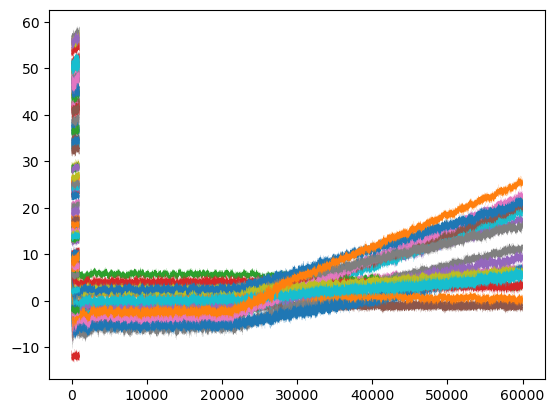

In [41]:
test.full_index
hor_pos = test.hor_turn_position
for l in hor_pos:
    plt.plot(l, '--', lw=0.1)

In [44]:
bpms_hor = test.bpms_hor

In [45]:
s_pos = line.get_s_position([f'{bpm}..0' for bpm in bpms_hor if f'{bpm}..0' in line.element_names])

In [50]:
len(l)

1024

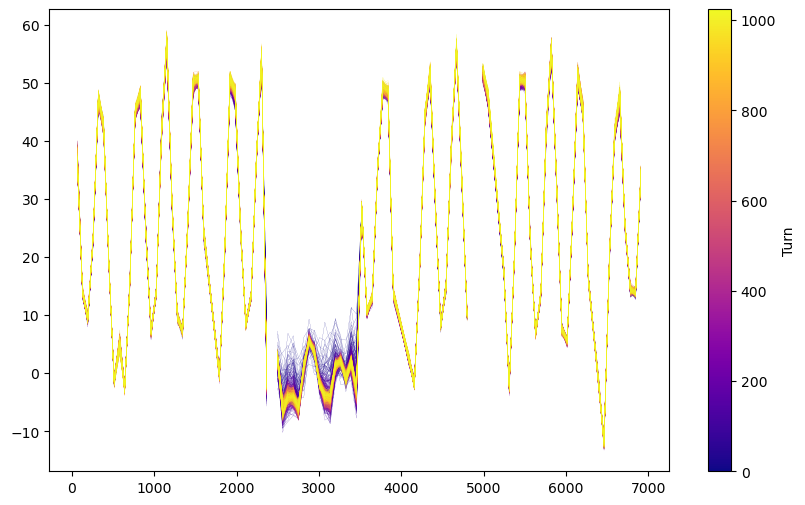

In [74]:
fig, ax = plt.subplots(figsize=(10, 6))
n_turns = 1024

cmap = plt.get_cmap('plasma', n_turns)
for i in range(len(hor_pos[0])):
    ax.plot(s_pos, hor_pos[:-1,i], lw=0.1, color=cmap(i))

norm = Normalize(vmin=0, vmax=n_turns)
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add colorbar
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label("Turn")

In [68]:
test['BPMALPS_1/CaptureAcquisition']['value']['position_unit'][0], test['BPMALPS_1/CaptureAcquisition']['value']['position_unitExponen']

(<Record {JAPC_ENUM: {code: 3, ...}} type='{JAPC_ENUM: ?{code: ?int64, strin...'>,
 <Array [-3] type='1 * ?int32'>)

In [69]:
test['BPMALPS_1/CaptureAcquisition']['value']['position_unit'][0]

<Record {JAPC_ENUM: {code: 3, ...}} type='{JAPC_ENUM: ?{code: ?int64, strin...'>

In [57]:
test['BPMALPS_1/CaptureAcquisition']['value']['positions'][0][0]

<Array [1.31, 1.01, 1.28, 1.03, ..., 1.14, 1.27, 1.54] type='1024 * ?float32'>

# New radial steering

In [86]:
bpm_dict['2025.06.16.20.04.15.339607']['BPMALPS_1/CaptureAcquisition']['header']['acqStamp']

<Array [1750097054135068125] type='1 * ?int64'>

In [ ]:
pd.to_datetime(1750097050935000000, ts=)

Timestamp('2025-06-16 18:04:10.935000')

In [87]:
pd.to_datetime(1750097054135068125)

Timestamp('2025-06-16 18:04:14.135068125')